# Import Original Data

In [20]:
import pandas as pd
df = pd.read_csv('data.csv')

In [21]:
df

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH
0,0.45,400,0,7,0.00,22.57
1,0.45,400,0,7,0.00,29.51
2,0.45,400,0,7,0.00,20.66
3,0.45,400,0,7,0.05,25.30
4,0.45,400,0,7,0.05,24.03
...,...,...,...,...,...,...
265,0.55,0,350,56,0.15,29.66
266,0.55,0,350,56,0.15,29.71
267,0.55,0,350,56,0.20,27.44
268,0.55,0,350,56,0.20,31.58


In [25]:
from pycaret.regression import *

# prompt: Use Darts to predict Strength
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = df.drop('STRENGTH', axis=1)
y = df['STRENGTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a PyCaret regression experiment
# Added index=False to avoid issues with duplicate indices
reg_exp = setup(data=df, target='STRENGTH', session_id=123)

# Predict on unseen data (if you have any)
# predictions = predict_model(tuned_best_model, data=unseen_data)

,Description,Value
0,Session id,123
1,Target,STRENGTH
2,Target type,Regression
3,Original data shape,"(270, 6)"
4,Transformed data shape,"(270, 6)"
5,Transformed train set shape,"(189, 6)"
6,Transformed test set shape,"(81, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [26]:
# Compare different regression models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.5954,10.2305,3.1579,0.9356,0.0908,0.0774,0.0360
gbr,Gradient Boosting Regressor,2.6934,11.1376,3.2865,0.9299,0.0931,0.0801,0.0060
rf,Random Forest Regressor,2.8967,12.5034,3.5157,0.9216,0.1004,0.0863,0.0160
knn,K Neighbors Regressor,2.9203,13.2217,3.5510,0.9171,0.0992,0.0855,0.0070
ada,AdaBoost Regressor,3.0062,14.9344,3.7472,0.9079,0.1051,0.0886,0.0050
et,Extra Trees Regressor,3.1587,15.0855,3.8622,0.9049,0.1114,0.0946,0.0120
xgboost,Extreme Gradient Boosting,3.2000,15.1649,3.8744,0.9042,0.1123,0.0961,0.0060
dt,Decision Tree Regressor,3.2426,15.8827,3.9587,0.9003,0.1138,0.0975,0.0040
lar,Least Angle Regression,4.7495,33.4201,5.7305,0.7850,0.1620,0.1412,0.0040
lr,Linear Regression,4.7495,33.4201,5.7305,0.7850,0.1620,0.1412,0.0040


In [27]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3266,8.6447,2.9402,0.9347,0.0912,0.0764
1,2.2865,9.4981,3.0819,0.9505,0.0815,0.0642
2,3.3892,16.4265,4.0530,0.8932,0.0951,0.0846
3,2.5935,9.0449,3.0075,0.9459,0.1134,0.1011
4,2.3642,10.2574,3.2027,0.9182,0.0879,0.0646
5,2.9756,13.2263,3.6368,0.9194,0.1278,0.1050
6,2.7233,9.9209,3.1498,0.9501,0.0995,0.0829
7,2.2277,7.1240,2.6691,0.9496,0.0701,0.0585
8,2.1299,6.9059,2.6279,0.9497,0.0780,0.0658


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Generate New Data

In [28]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name='data')

In [29]:
metadata

{
    "tables": {
        "data": {
            "columns": {
                "WBRatio": {
                    "sdtype": "numerical"
                },
                "OPC": {
                    "sdtype": "categorical"
                },
                "PPC": {
                    "sdtype": "categorical"
                },
                "DAYS": {
                    "sdtype": "categorical"
                },
                "CO2": {
                    "sdtype": "numerical"
                },
                "STRENGTH": {
                    "sdtype": "numerical"
                }
            }
        }
    },
    "relationships": [],
    "METADATA_SPEC_VERSION": "V1"
}

In [30]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=False,
    epochs=10000,
    discriminator_lr=0.0002,
    generator_lr=0.0002,
    batch_size=64,
    verbose=True
)

In [31]:
synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(df)

In [32]:
# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=200000)

In [33]:
synthetic_data

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH
0,0.44,0,0,7,0.02,13.56
1,0.47,500,350,7,0.04,28.34
2,0.44,0,400,28,0.03,32.79
3,0.35,400,0,28,0.20,21.23
4,0.46,0,0,7,0.01,31.99
...,...,...,...,...,...,...
199995,0.53,0,350,28,0.12,13.56
199996,0.45,0,0,7,0.14,13.56
199997,0.43,350,0,28,0.09,22.59
199998,0.36,0,500,7,0.07,49.66


In [34]:
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality

# Run diagnostic
diagnostic_report = run_diagnostic(real_data=df, synthetic_data=synthetic_data, metadata=metadata)
print("Diagnostic Report:")
print(diagnostic_report)

# Evaluate quality
quality_score = evaluate_quality(real_data=df, synthetic_data=synthetic_data, metadata=metadata)
print("Quality Evaluation:")

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 6/6 [00:00<00:00, 924.77it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 923.04it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report:
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 92.31it/s]|
Column Shapes Score: 84.57%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 88.23it/s]|
Column Pair Trends Score: 61.82%

Overall Score (Average): 73.2%

Quality Evaluation:


In [36]:
refined_data = pd.concat([df, synthetic_data], ignore_index=True)

In [37]:
refined_data

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH
0,0.45,400,0,7,0.00,22.57
1,0.45,400,0,7,0.00,29.51
2,0.45,400,0,7,0.00,20.66
3,0.45,400,0,7,0.05,25.30
4,0.45,400,0,7,0.05,24.03
...,...,...,...,...,...,...
200265,0.53,0,350,28,0.12,13.56
200266,0.45,0,0,7,0.14,13.56
200267,0.43,350,0,28,0.09,22.59
200268,0.36,0,500,7,0.07,49.66


In [38]:
reg_exp = setup(data=refined_data, target='STRENGTH', session_id=123)
best_model = compare_models()
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,Description,Value
0,Session id,123
1,Target,STRENGTH
2,Target type,Regression
3,Original data shape,"(200270, 6)"
4,Transformed data shape,"(200270, 6)"
5,Transformed train set shape,"(140189, 6)"
6,Transformed test set shape,"(60081, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.5642,156.9147,12.5263,0.0164,0.4560,0.4801,0.4420
lightgbm,Light Gradient Boosting Machine,10.5597,157.0212,12.5306,0.0158,0.4560,0.4797,0.2950
xgboost,Extreme Gradient Boosting,10.5837,158.3971,12.5854,0.0071,0.4579,0.4804,0.0860
ridge,Ridge Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0270
lar,Least Angle Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0270
br,Bayesian Ridge,10.6573,159.2189,12.6180,0.0020,0.4597,0.4854,0.0300
lr,Linear Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0260
en,Elastic Net,10.6632,159.3617,12.6237,0.0011,0.4599,0.4858,0.0270
llar,Lasso Least Angle Regression,10.6634,159.3636,12.6237,0.0011,0.4599,0.4858,0.0270
lasso,Lasso Regression,10.6634,159.3636,12.6237,0.0011,0.4599,0.4858,0.0280


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.5729,156.9495,12.5279,0.0131,0.4576,0.4840
1,10.6557,158.9362,12.6070,0.0128,0.4583,0.4839
2,10.5806,157.5717,12.5528,0.0130,0.4548,0.4772
3,10.4457,153.6852,12.3970,0.0140,0.4528,0.4765
4,10.6900,160.2815,12.6602,0.0121,0.4596,0.4851
5,10.5618,155.8139,12.4825,0.0131,0.4559,0.4807
6,10.5977,157.4966,12.5498,0.0115,0.4569,0.4818
7,10.5705,156.0204,12.4908,0.0139,0.4566,0.4830
8,10.6363,159.0263,12.6106,0.0136,0.4573,0.4810


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features and target
X = refined_data.drop(columns=['STRENGTH'])  # Replace 'STRENGTH' with your target column name
y = refined_data['STRENGTH']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
reg_exp = setup(data=pd.concat([X, y], axis=1), target='STRENGTH', session_id=123, index=False)
best_model = compare_models()
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,Description,Value
0,Session id,123
1,Target,STRENGTH
2,Target type,Regression
3,Original data shape,"(200270, 6)"
4,Transformed data shape,"(200270, 6)"
5,Transformed train set shape,"(140189, 6)"
6,Transformed test set shape,"(60081, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.5642,156.9147,12.5263,0.0164,0.4560,0.4801,0.4420
lightgbm,Light Gradient Boosting Machine,10.5597,157.0212,12.5306,0.0158,0.4560,0.4797,0.2860
xgboost,Extreme Gradient Boosting,10.5837,158.3971,12.5854,0.0071,0.4579,0.4804,0.0880
ridge,Ridge Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0230
lar,Least Angle Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0240
br,Bayesian Ridge,10.6573,159.2189,12.6180,0.0020,0.4597,0.4854,0.0240
lr,Linear Regression,10.6571,159.2186,12.6180,0.0020,0.4597,0.4854,0.0240
en,Elastic Net,10.6632,159.3617,12.6237,0.0011,0.4599,0.4858,0.0230
llar,Lasso Least Angle Regression,10.6634,159.3636,12.6237,0.0011,0.4599,0.4858,0.0230
lasso,Lasso Regression,10.6634,159.3636,12.6237,0.0011,0.4599,0.4858,0.0240


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.5729,156.9495,12.5279,0.0131,0.4576,0.4840
1,10.6557,158.9362,12.6070,0.0128,0.4583,0.4839
2,10.5806,157.5717,12.5528,0.0130,0.4548,0.4772
3,10.4457,153.6852,12.3970,0.0140,0.4528,0.4765
4,10.6900,160.2815,12.6602,0.0121,0.4596,0.4851
5,10.5618,155.8139,12.4825,0.0131,0.4559,0.4807
6,10.5977,157.4966,12.5498,0.0115,0.4569,0.4818
7,10.5705,156.0204,12.4908,0.0139,0.4566,0.4830
8,10.6363,159.0263,12.6106,0.0136,0.4573,0.4810


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [41]:
# Retain 20x the size of real data from synthetic data
sampled_synthetic_data = synthetic_data.sample(n=len(df) * 20, random_state=42)

# Combine with real data
refined_combined_data = pd.concat([df, sampled_synthetic_data], ignore_index=True)


In [42]:
refined_combined_data

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH
0,0.45,400,0,7,0.00,22.57
1,0.45,400,0,7,0.00,29.51
2,0.45,400,0,7,0.00,20.66
3,0.45,400,0,7,0.05,25.30
4,0.45,400,0,7,0.05,24.03
...,...,...,...,...,...,...
5665,0.44,400,0,7,0.08,27.18
5666,0.43,500,350,7,0.12,14.23
5667,0.52,500,0,7,0.18,41.41
5668,0.55,350,0,7,0.12,13.56


In [44]:
reg_exp = setup(data=refined_combined_data, target='STRENGTH', session_id=123)
best_model = compare_models()
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,Description,Value
0,Session id,123
1,Target,STRENGTH
2,Target type,Regression
3,Original data shape,"(5670, 6)"
4,Transformed data shape,"(5670, 6)"
5,Transformed train set shape,"(3968, 6)"
6,Transformed test set shape,"(1702, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,10.7200,162.6514,12.7501,0.0189,0.4594,0.4818,0.0140
ridge,Ridge Regression,10.8636,165.4655,12.8599,0.0021,0.4624,0.4882,0.0040
lar,Least Angle Regression,10.8621,165.4705,12.8600,0.0021,0.4624,0.4881,0.0030
lr,Linear Regression,10.8621,165.4705,12.8600,0.0021,0.4624,0.4881,0.0040
dummy,Dummy Regressor,10.8966,166.1798,12.8879,-0.0023,0.4634,0.4897,0.0040
omp,Orthogonal Matching Pursuit,10.8962,166.1809,12.8882,-0.0024,0.4633,0.4896,0.0040
br,Bayesian Ridge,10.8981,166.2357,12.8902,-0.0027,0.4634,0.4897,0.0030
en,Elastic Net,10.8993,166.2566,12.8911,-0.0028,0.4634,0.4898,0.0040
llar,Lasso Least Angle Regression,10.8994,166.2565,12.8911,-0.0028,0.4634,0.4898,0.0030
lasso,Lasso Regression,10.8994,166.2565,12.8911,-0.0028,0.4634,0.4898,0.0030


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10.7805,170.3553,13.0520,0.0101,0.4668,0.4932
1,10.9993,169.1929,13.0074,0.0390,0.4663,0.4957
2,10.4269,149.5002,12.2270,-0.0035,0.4590,0.5006
3,10.7367,162.3189,12.7404,0.0392,0.4576,0.4790
4,11.1147,167.0239,12.9238,-0.0115,0.4662,0.4896
5,10.3414,157.8088,12.5622,0.0296,0.4455,0.4571
6,10.6703,155.2891,12.4615,0.0073,0.4573,0.4874
7,10.7366,163.4135,12.7833,0.0294,0.4562,0.4746
8,10.9341,170.0975,13.0421,0.0098,0.4689,0.4946


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Cluster real data
kmeans = KMeans(n_clusters=5, random_state=42)
real_clusters = kmeans.fit_predict(df.drop(columns=['STRENGTH']))

# Assign synthetic data to nearest cluster
synthetic_features = synthetic_data.drop(columns=['STRENGTH'])
synthetic_clusters = kmeans.predict(synthetic_features)
_, distances = pairwise_distances_argmin_min(synthetic_features, kmeans.cluster_centers_)

# Filter synthetic data close to cluster centers
threshold = distances.mean() + distances.std()
filtered_synthetic_data = synthetic_data[distances < threshold]


ValueError: could not convert string to float: 'real'

In [ ]:
New_data

In [ ]:
from pycaret.regression import *

# prompt: Use Darts to predict Strength
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a PyCaret regression experiment
# Added index=False to avoid issues with duplicate indices
reg_exp = setup(data=New_data, target='STRENGTH', session_id=123)

# Predict on unseen data (if you have any)
# predictions = predict_model(tuned_best_model, data=unseen_data)

In [ ]:
# Compare different regression models
best_model = compare_models()

In [ ]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

# Filter Synthetic Data DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Example loop for tuning DBSCAN
best_eps = None
best_min_samples = None
best_silhouette = -1  # Silhouette score ranges from -1 to 1

for eps in np.arange(0.5, 2.0, 0.1):
    for min_samples in range(3, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_features)
        
        # Ignore results with noise-only clustering
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(scaled_features, labels)
            if silhouette_avg > best_silhouette:
                best_eps, best_min_samples, best_silhouette = eps, min_samples, silhouette_avg

print(f"Best DBSCAN Params: eps={best_eps}, min_samples={best_min_samples}, silhouette_score={best_silhouette}")


In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Add cluster labels to the dataset
New_data['dbscan_cluster'] = dbscan_labels

In [ ]:
New_data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

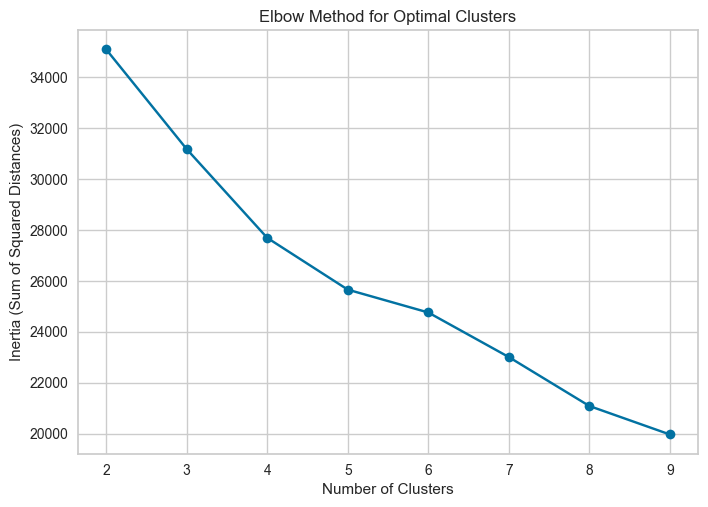

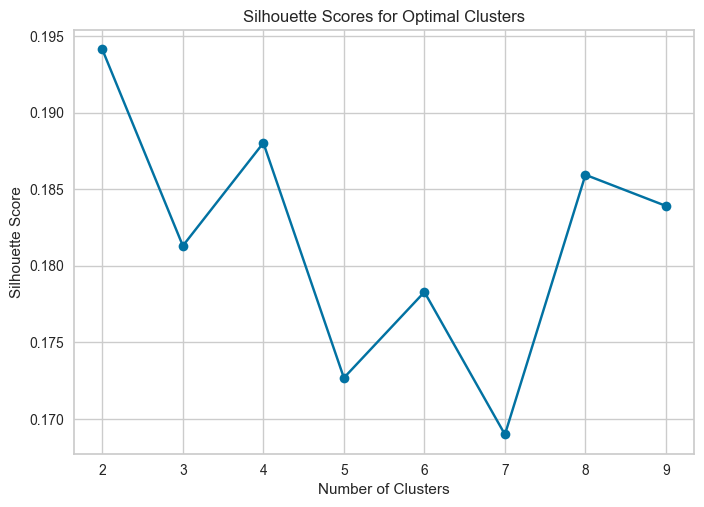

Optimal Number of Clusters: 2


In [139]:
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

# Plot the Elbow Method
import matplotlib.pyplot as plt
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Plot Silhouette Scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Clusters')
plt.show()

# Get the optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")


In [140]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
New_data['kmeans_cluster'] = kmeans_labels

ValueError: Length of values (7180) does not match length of index (20270)

In [ ]:
# Example: Retain synthetic data from majority real clusters
real_data = New_data[New_data['source'] == 'real']
synthetic_data = New_data[New_data['source'] == 'synthetic']

# Find majority clusters for real data
majority_clusters = real_data['kmeans_cluster'].value_counts().index[:3]

# Retain synthetic samples in majority clusters
filtered_synthetic_data = synthetic_data[synthetic_data['kmeans_cluster'].isin(majority_clusters)]

# Combine filtered synthetic data with real data
refined_data = pd.concat([real_data, filtered_synthetic_data], ignore_index=True)

In [ ]:
refined_data.drop(columns=['source', 'dbscan_cluster','kmeans_cluster'], inplace=True)
refined_data

In [ ]:
reg_exp = setup(data=refined_data, target='STRENGTH', session_id=123)

In [ ]:
# Compare different regression models
best_model = compare_models()

In [ ]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare real and synthetic data
real_data = df.copy()
synthetic_data = refined_data.copy()
real_data['source'] = 'real'
synthetic_data['source'] = 'synthetic'
combined_data = pd.concat([real_data, synthetic_data], ignore_index=True)

# Extract numeric features and handle missing values
features = combined_data.drop(columns=['source'], errors='ignore').apply(pd.to_numeric, errors='coerce').fillna(0)

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine optimal DBSCAN parameters (optional, via k-distance plot)
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("k-distance Plot for DBSCAN")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5, metric='euclidean')
combined_data['cluster'] = dbscan.fit_predict(scaled_features)


In [ ]:
# Visualize clustering with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=combined_data['cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
# Add the 'cluster' column to the original real and synthetic datasets
real_data['cluster'] = combined_data[combined_data['source'] == 'real']['cluster'].values
synthetic_data['cluster'] = combined_data[combined_data['source'] == 'synthetic']['cluster'].values

# Filter synthetic data that aligns with valid clusters from real data
valid_clusters = set(real_data['cluster'])  # Get valid clusters from real data
filtered_synthetic_data = synthetic_data[synthetic_data['cluster'].isin(valid_clusters)]

print(f"Original Synthetic Data Size: {len(synthetic_data)}")
print(f"Filtered Synthetic Data Size: {len(filtered_synthetic_data)}")

In [ ]:
filtered_synthetic_data

In [ ]:
# Drop 'source' and 'cluster' columns from the dataframe
filtered_synthetic_data.drop(columns=['source', 'cluster'], inplace=True)

In [ ]:
filtered_synthetic_data

In [ ]:
from pycaret.regression import *

# prompt: Use Darts to predict Strength
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = filtered_synthetic_data.drop('STRENGTH', axis=1)
y = filtered_synthetic_data['STRENGTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a PyCaret regression experiment
# Added index=False to avoid issues with duplicate indices
reg_exp = setup(data=pd.concat([X, y], axis=1), target='STRENGTH', session_id=123, index=False)

# Predict on unseen data (if you have any)
# predictions = predict_model(tuned_best_model, data=unseen_data)

In [ ]:
# Compare different regression models
best_model = compare_models()

In [ ]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

In [ ]:
# Combine with real data
combined_data = pd.concat([real_data, filtered_synthetic_data], ignore_index=True)

combined_data.drop(columns=['source', 'cluster'], inplace=True)
# Train the model again and evaluate

In [ ]:
combined_data

In [ ]:
from pycaret.regression import *

# prompt: Use Darts to predict Strength
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = combined_data.drop('STRENGTH', axis=1)
y = combined_data['STRENGTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a PyCaret regression experiment
# Added index=False to avoid issues with duplicate indices
reg_exp = setup(data=pd.concat([X, y], axis=1), target='STRENGTH', session_id=123, index=False)

# Predict on unseen data (if you have any)
# predictions = predict_model(tuned_best_model, data=unseen_data)

In [141]:
# Compare different regression models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8.2973,103.8825,10.1851,0.3448,0.3059,0.2775,0.0100
ada,AdaBoost Regressor,8.7263,109.1856,10.4458,0.3104,0.3098,0.2849,0.0050
lightgbm,Light Gradient Boosting Machine,8.4351,111.3606,10.5407,0.2973,0.3133,0.2805,0.1490
lar,Least Angle Regression,8.8570,113.3568,10.6403,0.2845,0.3165,0.2934,0.0030
br,Bayesian Ridge,8.8573,113.3593,10.6404,0.2845,0.3165,0.2935,0.0030
lr,Linear Regression,8.8570,113.3568,10.6403,0.2845,0.3165,0.2934,0.0040
ridge,Ridge Regression,8.8664,113.5806,10.6507,0.2833,0.3169,0.2943,0.0030
huber,Huber Regressor,8.8477,113.7588,10.6586,0.2822,0.3179,0.2958,0.0040
rf,Random Forest Regressor,8.7451,123.8790,11.1156,0.2178,0.3288,0.2888,0.0190
knn,K Neighbors Regressor,8.8543,124.0309,11.1293,0.2168,0.3286,0.2932,0.0070


In [142]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8598,114.5565,10.7031,0.3249,0.3280,0.3126
1,8.1711,97.6484,9.8817,0.3329,0.2720,0.2381
2,8.4300,103.0436,10.1510,0.3785,0.3002,0.2760
3,8.3294,106.9966,10.3439,0.3060,0.3099,0.2807
4,8.4851,107.8388,10.3845,0.3185,0.3148,0.2900
5,7.9940,95.8217,9.7889,0.3178,0.2872,0.2537
6,8.7000,114.1535,10.6843,0.2587,0.3322,0.3079
7,9.0985,122.3300,11.0603,0.3238,0.3323,0.3131
8,8.6325,109.1070,10.4454,0.3192,0.3329,0.3133


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Apply K Means 

In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Drop non-numeric columns and ensure consistency
real_features = real_data.drop(columns=['source', 'cluster'], errors='ignore').select_dtypes(include=[np.number])
synthetic_features = filtered_synthetic_data.drop(columns=['source', 'cluster'], errors='ignore').select_dtypes(include=[np.number])

# Handle any missing values
real_features = real_features.fillna(0)
synthetic_features = synthetic_features.fillna(0)

# Scale features
scaler = StandardScaler()
real_features_scaled = scaler.fit_transform(real_features)
synthetic_features_scaled = scaler.transform(synthetic_features)

# Use KMeans to cluster real data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(real_features_scaled)

# Assign synthetic data to clusters and compute distances
distances = euclidean_distances(synthetic_features_scaled, kmeans.cluster_centers_)

# Retain synthetic points closest to cluster centers
retained_synthetic_indices = distances.min(axis=1).argsort()[:len(real_data) * 10]
refined_synthetic_data = filtered_synthetic_data.iloc[retained_synthetic_indices]

# Combine refined synthetic data with real data
refined_combined_data = pd.concat([real_data, refined_synthetic_data], ignore_index=True)

# Prepare features and target for model retraining
X = refined_combined_data.drop(columns=['STRENGTH'], errors='ignore')
y = refined_combined_data['STRENGTH']

In [144]:
refined_combined_data

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH,source,cluster
0,0.45,400,0,7,0.00,22.57,real,0.0
1,0.45,400,0,7,0.00,29.51,real,0.0
2,0.45,400,0,7,0.00,20.66,real,0.0
3,0.45,400,0,7,0.05,25.30,real,0.0
4,0.45,400,0,7,0.05,24.03,real,0.0
...,...,...,...,...,...,...,...,...
2965,0.55,500,0,28,0.07,50.57,NaN,NaN
2966,0.36,350,0,56,0.05,63.12,NaN,NaN
2967,0.55,0,350,7,0.15,45.30,NaN,NaN
2968,0.55,0,500,7,0.20,33.96,NaN,NaN


In [145]:
refined_combined_data.drop(columns=['source', 'cluster'], inplace=True)

In [146]:
refined_combined_data

,WBRatio,OPC,PPC,DAYS,CO2,STRENGTH
0,0.45,400,0,7,0.00,22.57
1,0.45,400,0,7,0.00,29.51
2,0.45,400,0,7,0.00,20.66
3,0.45,400,0,7,0.05,25.30
4,0.45,400,0,7,0.05,24.03
...,...,...,...,...,...,...
2965,0.55,500,0,28,0.07,50.57
2966,0.36,350,0,56,0.05,63.12
2967,0.55,0,350,7,0.15,45.30
2968,0.55,0,500,7,0.20,33.96


In [147]:
from pycaret.regression import *

# prompt: Use Darts to predict Strength
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = refined_combined_data.drop('STRENGTH', axis=1)
y = refined_combined_data['STRENGTH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a PyCaret regression experiment
# Added index=False to avoid issues with duplicate indices
reg_exp = setup(data=pd.concat([X, y], axis=1), target='STRENGTH', session_id=123, index=False)

# Predict on unseen data (if you have any)
# predictions = predict_model(tuned_best_model, data=unseen_data)

,Description,Value
0,Session id,123
1,Target,STRENGTH
2,Target type,Regression
3,Original data shape,"(2970, 6)"
4,Transformed data shape,"(2970, 6)"
5,Transformed train set shape,"(2079, 6)"
6,Transformed test set shape,"(891, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [148]:
# Compare different regression models
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8.2973,103.8825,10.1851,0.3448,0.3059,0.2775,0.0110
ada,AdaBoost Regressor,8.7263,109.1856,10.4458,0.3104,0.3098,0.2849,0.0050
lightgbm,Light Gradient Boosting Machine,8.4351,111.3606,10.5407,0.2973,0.3133,0.2805,0.1520
lar,Least Angle Regression,8.8570,113.3568,10.6403,0.2845,0.3165,0.2934,0.0040
br,Bayesian Ridge,8.8573,113.3593,10.6404,0.2845,0.3165,0.2935,0.0040
lr,Linear Regression,8.8570,113.3568,10.6403,0.2845,0.3165,0.2934,0.0040
ridge,Ridge Regression,8.8664,113.5806,10.6507,0.2833,0.3169,0.2943,0.0040
huber,Huber Regressor,8.8477,113.7588,10.6586,0.2822,0.3179,0.2958,0.0050
rf,Random Forest Regressor,8.7451,123.8790,11.1156,0.2178,0.3288,0.2888,0.0180
knn,K Neighbors Regressor,8.8543,124.0309,11.1293,0.2168,0.3286,0.2932,0.0060


In [149]:
# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8598,114.5565,10.7031,0.3249,0.3280,0.3126
1,8.1711,97.6484,9.8817,0.3329,0.2720,0.2381
2,8.4300,103.0436,10.1510,0.3785,0.3002,0.2760
3,8.3294,106.9966,10.3439,0.3060,0.3099,0.2807
4,8.4851,107.8388,10.3845,0.3185,0.3148,0.2900
5,7.9940,95.8217,9.7889,0.3178,0.2872,0.2537
6,8.7000,114.1535,10.6843,0.2587,0.3322,0.3079
7,9.0985,122.3300,11.0603,0.3238,0.3323,0.3131
8,8.6325,109.1070,10.4454,0.3192,0.3329,0.3133


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [150]:
from pycaret.regression import save_model

# Example: Assume 'best_model' is the trained PyCaret model
save_model(best_model, 'best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['WBRatio', 'OPC', 'PPC', 'DAYS',
                                              'CO2'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model', GradientBoostingRegressor(random_state=123))]),
 'best_model.pkl')

In [151]:
from pycaret.regression import load_model

# Load the pre-trained model
model = load_model('best_model')

Transformation Pipeline and Model Successfully Loaded


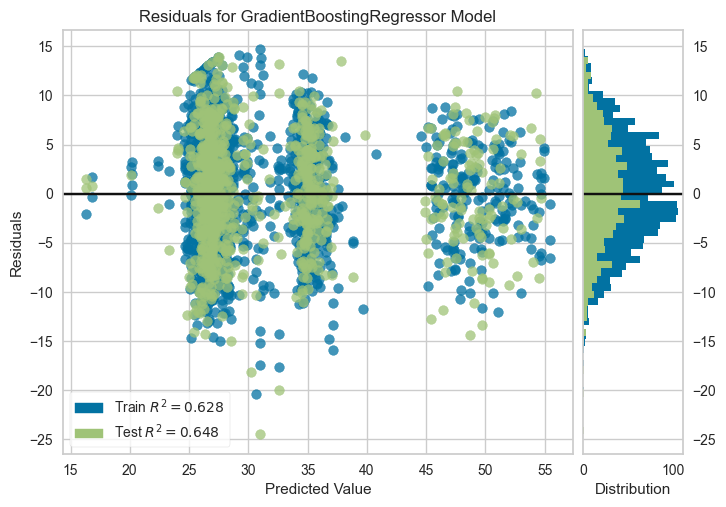

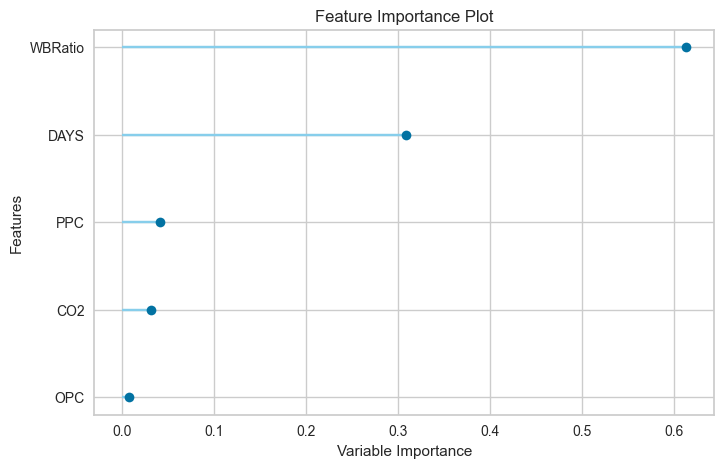

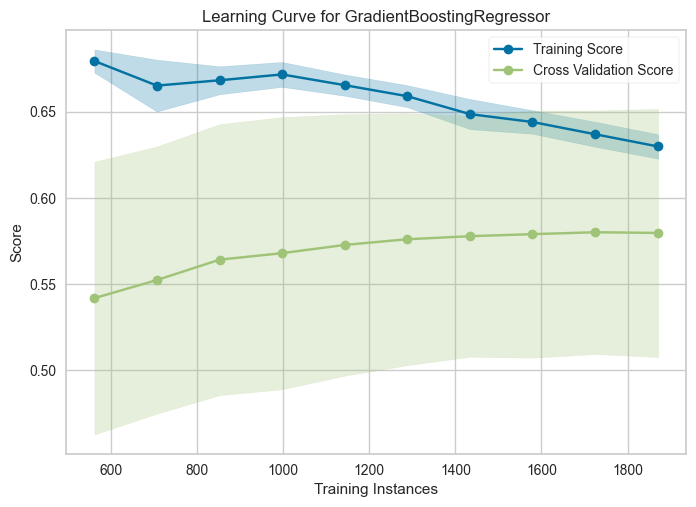

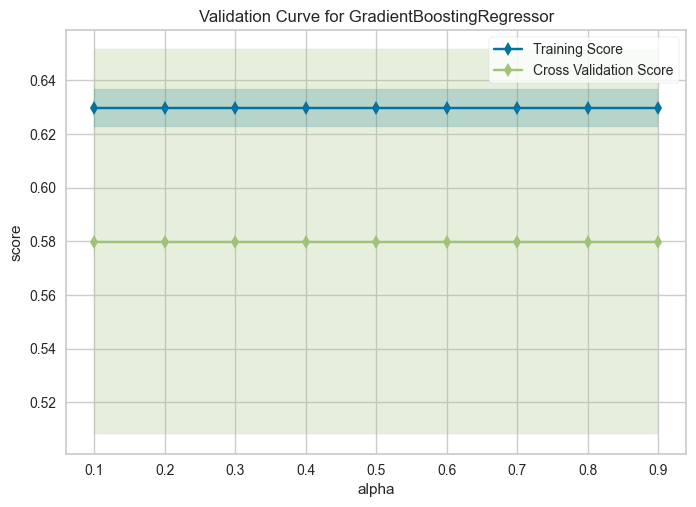

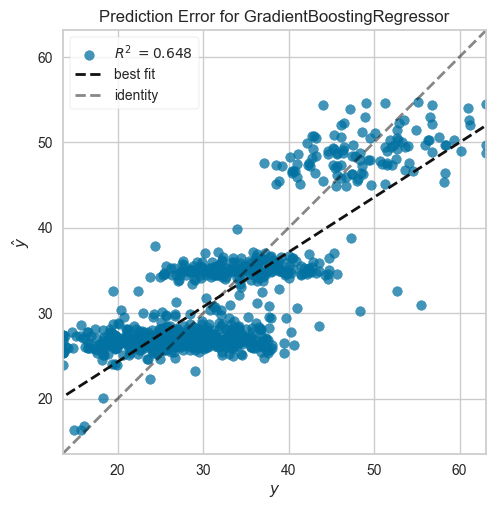

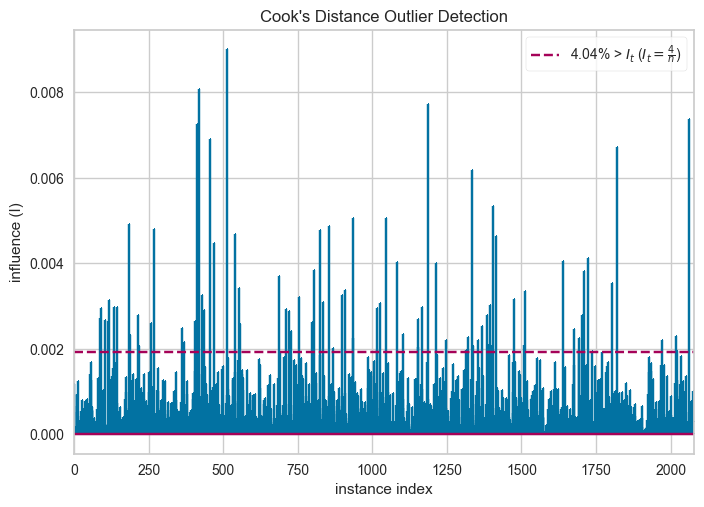

In [135]:
import matplotlib.pyplot as plt
from pycaret.regression import *

# Assuming you've already set up your environment and trained the model
# setup(data=refined_combined_data, target='STRENGTH')  # Uncomment if setup is not done
# model = create_model('lightgbm')  # Your trained model

# List of available plot types in PyCaret for regression models
plot_types = [
    'residuals', 'feature', 'learning', 'vc', 
    'error', 'cooks']

# Loop through each plot type and save it
for plot_type in plot_types:
    # Generate the plot
    plot_model(model, plot=plot_type)

In [69]:
from pycaret.regression import *

# Assuming the environment is set up, and the model is trained
# setup(data=refined_combined_data, target='STRENGTH')  # Uncomment if setup is not done
# model = create_model('lightgbm')  # Replace with your trained model

# List of available plot types
plot_types = [
    'residuals', 'feature', 'learning', 'vc', 
    'error', 'cooks']

# Save each plot
for plot_type in plot_types:
    # Generate and save the plot
    plot_model(model, plot=plot_type, save=True)

In [70]:
X = refined_combined_data.drop(columns=['STRENGTH'])  # Replace 'target_column' with your target feature name

In [71]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(best_model.predict, X)
shap_values = explainer(X)

ExactExplainer explainer: 2971it [00:11, 41.22it/s]                           


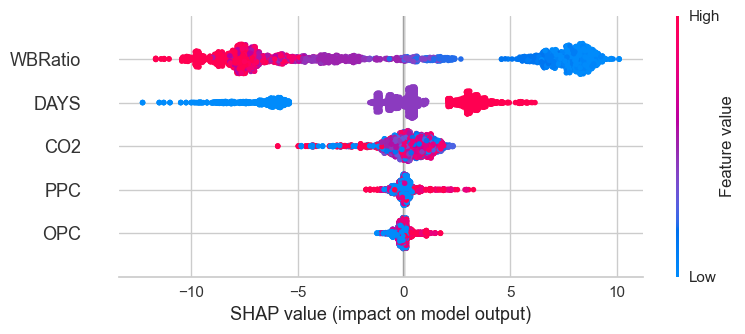

In [72]:
shap.summary_plot(shap_values, X)

In [73]:
import shap
import matplotlib.pyplot as plt

# Assuming `shap_values` and `X` are already defined
# Generate the summary plot
plt.figure()  # Create a new figure
shap.summary_plot(shap_values, X, show=False)  # `show=False` prevents it from displaying

# Save the plot as a PDF with high resolution
plt.savefig("shap_summary_plot.pdf", format="pdf", dpi=1200)

# Close the plot to free memory
plt.close()

In [74]:
shap.initjs()

In [75]:
# Force plot for the first prediction
shap.force_plot(
    shap_values.base_values[0],  # Base value of the model's output
    shap_values.values[0],       # SHAP values for the first row
    X.iloc[0, :]                 # Feature values for the first row
)

In [76]:
force_plot = shap.force_plot(
    shap_values.base_values[0],
    shap_values.values[0],
    X.iloc[0, :]
)

# Save the plot as an HTML file
shap.save_html('force_plot.html', force_plot)

In [77]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values and X are already defined
# Generate the force plot for the first prediction
force_plot = shap.force_plot(
    shap_values.base_values[0],  # Base value of the model's output
    shap_values.values[0],       # SHAP values for the first row
    X.iloc[0, :]                 # Feature values for the first row
)

# Save the force plot as a PDF
# First, we use `shap.save_html` to save it as an HTML file
shap.save_html("force_plot.html", force_plot)

# Then, we can use a library like `pdfkit` to convert the HTML to PDF, or use Matplotlib to save it as an image.
# To directly save it as a PDF, we will use the html2pdf approach:

import pdfkit
pdfkit.from_file("force_plot.html", "force_plot.pdf")

# The force plot is now saved as 'force_plot.pdf'

True

# END